shell script example to get testing data from BAM files and (stripped) VCF files
```
mkdir -p ./wd
cd ./wd
python ../helper_scripts/get_SNP_candidates.py --bam_file_fn ../testing_data/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam \
                                               --ref_fasta_fn ../testing_data/chr22/chr22.fa \
                                               --pm_count_fn pm_counts_chr22 --ctg_nam chr22
python ../helper_scripts/get_alignment_tensor.py --bam_file_fn ../testing_data/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam \
                                                 --pm_count_fn pm_counts_chr22 \
                                                 --ref_fasta_fn ../testing_data/chr22/chr22.fa \
                                                 --ctg_name chr22 > aln_tensor_chr22
python ../helper_scripts/get_variant_set.py < ../testing_data/chr22/chr22.vcf > variants_chr22
```

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# I have not written a python packaging script, load the NN class within the repository
import sys
sys.path.append('../')

In [4]:
#import variantNet as vn
import variantNet.utils as utils
import variantNet.vn as vn

In [5]:
# useful for testing
#reload(utils)
#reload(vn)

In [6]:
Xarray, Yarray, pos_array = \
utils.get_training_array("../wd/aln_tensor_chr21", 
                         "../wd/variants_chr21", 
                         "../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed" )

In [7]:
print Xarray.shape
print Yarray.shape

(53537, 15, 4, 3)
(53537, 8)


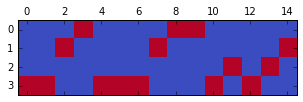

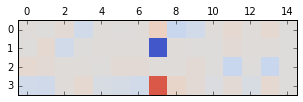

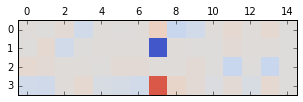

In [8]:
i = 999
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)

In [9]:
%%bash
mkdir -p ../wd/parameters

In [10]:
n = vn.VariantNet()

In [11]:
n.init()

In [12]:
batch_size = 500
validation_lost = []
for i in range(2401):
    Xbatch, Ybatch = utils.get_batch(Xarray[:30000], Yarray[:30000], size=batch_size)
    loss = n.train(Xbatch, Ybatch)
    if i % (len(Xarray[:30000])/batch_size) == 0:
        v_lost = n.get_loss( Xarray[30000:40000], Yarray[30000:40000] )
        print i, "train lost:", loss/batch_size, "validation lost", v_lost/10000
        n.save_parameters('../wd/parameters/vn.params-%04d' % i)
        validation_lost.append( (v_lost, i) )
        

0 train lost: 3.74287841797 validation lost 3.64796328125
60 train lost: 1.06825488281 validation lost 1.02078203125
120 train lost: 0.802602233887 validation lost 0.748889990234
180 train lost: 0.627106750488 validation lost 0.643667529297
240 train lost: 0.592438232422 validation lost 0.583578613281
300 train lost: 0.649790893555 validation lost 0.544902783203
360 train lost: 0.399657409668 validation lost 0.483504833984
420 train lost: 0.539160949707 validation lost 0.460812304688
480 train lost: 0.460912628174 validation lost 0.407081982422
540 train lost: 0.283929321289 validation lost 0.382255859375
600 train lost: 0.341383483887 validation lost 0.358508544922
660 train lost: 0.314120330811 validation lost 0.339563842773
720 train lost: 0.281826812744 validation lost 0.331615234375
780 train lost: 0.298485229492 validation lost 0.329188012695
840 train lost: 0.251700927734 validation lost 0.326593969727
900 train lost: 0.221171096802 validation lost 0.322357543945
960 train lost:

In [13]:
validation_lost.sort()
i = validation_lost[0][1]
print i
n.restore_parameters('../wd/parameters/vn.params-%04d' % i)

1920
INFO:tensorflow:Restoring parameters from ../wd/parameters/vn.params-1920


In [14]:
Xarray2, Yarray2, pos_array2 = \
utils.get_training_array("../wd/aln_tensor_chr22", 
                         "../wd/variants_chr22", 
                         "../testing_data/chr22/CHROM22_v.3.3.2_highconf_noinconsistent.bed" )

In [15]:
base, t = n.predict(Xarray2)

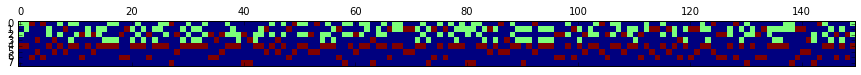

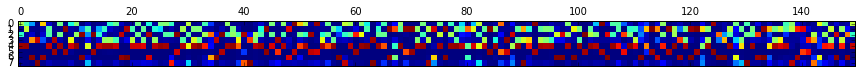

In [16]:
figure(figsize=(15, 5))
matshow(Yarray2[4000:4150,:].transpose(), fignum=0)
figure(figsize=(15, 5))
matshow(np.concatenate( (base[4000:4150,:],t[4000:4150,:]),1).transpose(), fignum=0)


In [17]:
evaluation_data = []
for pos, predict_v, annotate_v in zip(np.array(pos_array2), t, Yarray2[:,4:]):
    evaluation_data.append( (pos, np.argmax(predict_v), np.argmax(annotate_v)) )
evaluation_data = np.array(evaluation_data)

In [18]:
from collections import Counter

In [19]:
for i in range(4):
    cnt = Counter(evaluation_data[evaluation_data[:,2]==i,1])
    print i,"\t",
    for j in range(4):
        print cnt.get(j,0),"\t",
    print

0 	21185 	83 	292 	249 	
1 	81 	9557 	3 	50 	
2 	234 	5 	11974 	396 	
3 	684 	324 	233 	1884 	


In [20]:
ed = evaluation_data
print "Recall rate for het-call (regardless called variant types):", 1.0*sum((ed[:,1]!=2) & (ed[:,2]==0))/sum(ed[:,2]==0)
print "Recall rate for het-call (called variant type = het):", 1.0*sum((ed[:,1]==0) & (ed[:,2]==0))/sum(ed[:,2]==0)
print
print "PPV for het-call (regardless called variant types):", 1.0*sum((ed[:,1]==0) & (ed[:,2]!=2))/sum(ed[:,1]==0)
print "PPV for het-call (called variant type = het):", 1.0*sum((ed[:,1]==0) & (ed[:,2]==0))/sum(ed[:,1]==0)
print
print "Recall rate for hom-call (regardless called variant types):", 1.0*sum((ed[:,1]!=2) & (ed[:,2]==1))/sum(ed[:,2]==1)
print "Recall rate for hom-call (called variant type = hom):", 1.0*sum((ed[:,1]==1) & (ed[:,2]==1))/sum(ed[:,2]==1)
print
print "PPV for hom-call (regardless called variant types):", 1.0*sum((ed[:,1]==1) & (ed[:,2]!=2))/sum(ed[:,1]==1)
print "PPV for hom-call (called variant type = hom):", 1.0*sum((ed[:,1]==1) & (ed[:,2]==1))/sum(ed[:,1]==1)
print
print "Recall rate for all calls:", 1.0*sum((ed[:,1]!=2) & (ed[:,2]!=2))/sum(ed[:,2]!=2) 
print "PPV for all calls:", 1.0*sum((ed[:,1]!=2) & (ed[:,2]!=2))/sum(ed[:,1]!=2) 

Recall rate for het-call (regardless called variant types): 0.986611032143
Recall rate for het-call (called variant type = het): 0.971387959099

PPV for het-call (regardless called variant types): 0.989451857194
PPV for het-call (called variant type = het): 0.954967544176

Recall rate for hom-call (regardless called variant types): 0.999690434424
Recall rate for hom-call (called variant type = hom): 0.986172737592

PPV for hom-call (regardless called variant types): 0.99949844518
PPV for hom-call (called variant type = hom): 0.958671882837

Recall rate for all calls: 0.984750902527
PPV for all calls: 0.981717148451
